# pyBumpHunter Example

Simple notebook for testing the pyBumpHunter.py package.

We will use histograms ranging between 0 and 20 with 60 even bins.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pyBumpHunter as BH
from datetime import datetime  ## Used to compute the execution time
import uproot as upr  ## Used to read data from a root file

## Load input file

The data (in a ROOT file format) consists of three histograms: a steeply falling 'background' distribution in a [0,20] x-axis range, a 'signal' gaussian shape centered on a value of 5.5, and a 'data' distribution sampled from background and signal distributions, with a signal fraction of 0.15%.


In [2]:
# Open the file
File = upr.open('../data/data.root')
File.items()

# Background
bkg = File['bkg'].arrays(outputtype=np.array)

# Data
data = File['data'].arrays(outputtype=np.array)

# Signal
sig = File['sig'].arrays(outputtype=np.array)

# Position of the bump in the data
Lth = 5.5

# Range for the histogram
rang = [0,20]

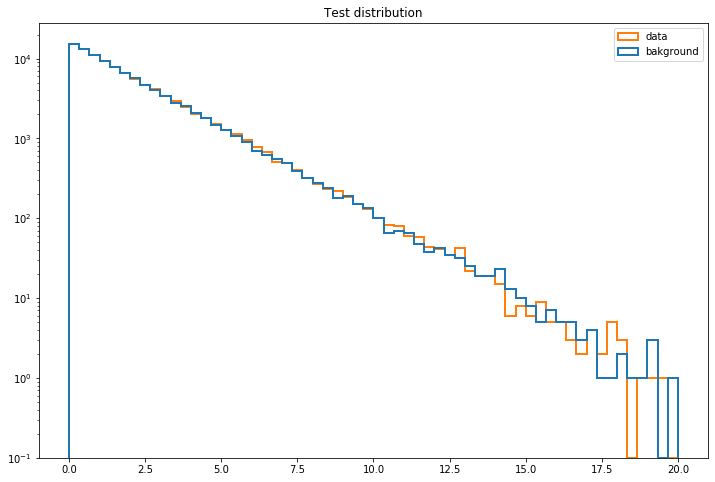

In [3]:
# Plot the 2 distributions (data and background)
F = plt.figure(figsize=(12,8))
plt.title('Test distribution')
plt.hist((bkg,data),bins=60,histtype='step',range=rang,label=('bakground','data'),linewidth=2,log=True)
plt.legend()
plt.show()

## Create a BumpHunter class instance.

The BumpHunter class provides all the methods required to "bump hunt" in ease.

All the parameters and results are also stored in this object.

In [4]:
BHtest = BH.BumpHunter(rang=rang,
                       width_min=2,
                       width_max=6,
                       width_step=1,
                       scan_step=1,
                       Npe=10000,
                       Nworker=1,
                       seed=666)

## Call the BumpScan Method

The function will scan the data distribution using variable-width window sizes (between width_min and width_max) and calculate the p-value of data with respect to the background for each window. The minimum p-value obtained from all windows is the local p-value.

To cope with the look-elsewhere effect a global p-value is calculated using a two-step procedure:
- the distribution of possible p-values is determined from background-only pseudo-experiments (npe parameter)
- the p-value found in data is compared to the background-only p-value distribution to calculate the global p-value

In [5]:
print('####BmupScan call####')
begin = datetime.now()
BHtest.BumpScan(data,bkg)
end = datetime.now()
print('time={}'.format(end-begin))
print('')

####BmupScan call####
Generating histograms
5 values of width will be tested
SCAN
Global p-value : 0.0177  (177 / 10000)
Significance = 2.10375

time=0:00:20.863122



## Print results of BH scan

Print information on more significant window ("bump"): location, width, excess over background events, global p-value and global significance.

In [6]:
BHtest.PrintBumpInfo()
BHtest.PrintBumpTrue(data,bkg)
print('   mean (true) = {}'.format(Lth))

BUMP WINDOW
   loc = 16
   width = 4
   local p-value | t = 0.00017341067835451395 | 8.659847913307976

BUMP POSITION
   min : 5.333
   max : 6.667
   mean : 6.000
   width : 1.333
   number of signal events : 208
   global p-value : 0.01770
   significance = 2.10375

   mean (true) = 5.5


## Tomography plot

This figure shows the p-value in each of the windows used to scan the data distribution.

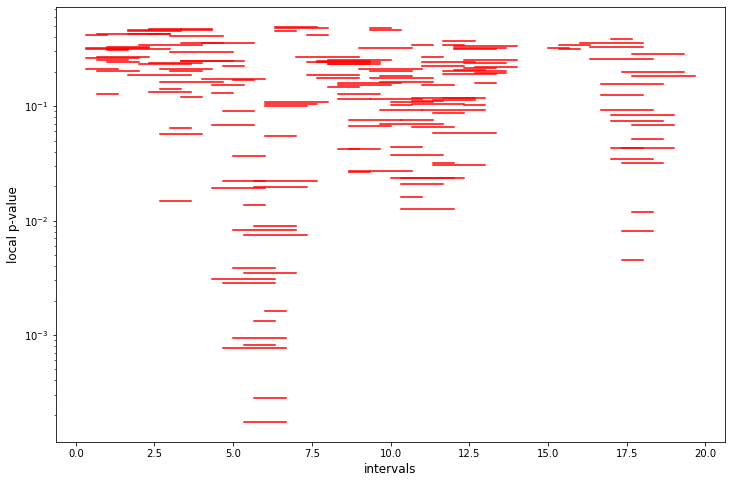

In [7]:
BHtest.GetTomography(data)

## Show most significant window

Window with the lowest p-value obtained from the data scans.

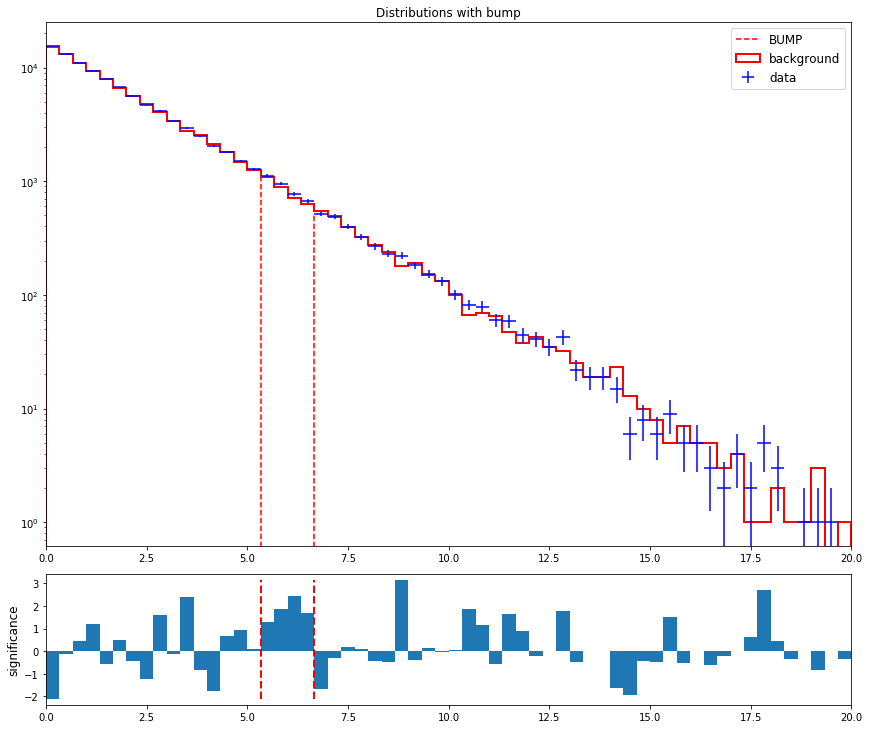

In [8]:
BHtest.PlotBump(data,bkg)

# Global p-value

This figure shows the test statistics (log(p-value)) obtained from background-only toys and the p-value obtained from data. The global p-value is equal to the fraction of background-only experiments whch have a higher test statistics than for the data (i.e this is the p-value of p-values).

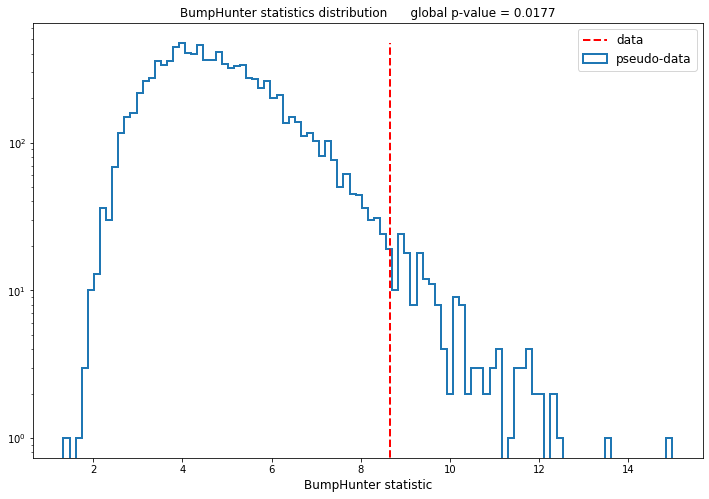

In [9]:
BHtest.PlotBHstat(show_Pval=True)

## Signal injection

Inject signal in data until a 5 sigma excess is found. 

In [10]:
# We have to set additionnal parameters specific to the signal injection.
# All the parameters defined previously are kept.
BHtest.sigma_limit = 5
BHtest.str_min = -1 # if str_scale='log', the real starting value is 10**str_min
BHtest.str_scale = 'log'
BHtest.signal_exp = 150 # Correspond the the real number of signal events generated when making the data

print('####SignalInject call####')
begin = datetime.now()
BHtest.SignalInject(sig,bkg,is_hist=False)
end = datetime.now()
print('time={}'.format(end-begin))
print('')

####SignalInject call####
Generating background only histograms
5 values of width will be tested
BACKGROUND ONLY SCAN
STARTING INJECTION
   STEP 1 : signal strength = 0.1
Generating background+signal histograms
BACKGROUND+SIGNAL SCAN
Global p-value : 0.0495  (495 / 10000)   0.0835  (835)   0.0152  (152)
Significance = 1.64972 (1.38191  2.16484)

   STEP 2 : signal strength = 0.2
Generating background+signal histograms
BACKGROUND+SIGNAL SCAN
Global p-value : 0.0464  (464 / 10000)   0.0808  (808)   0.0146  (146)
Significance = 1.68081 (1.39971  2.18078)

   STEP 3 : signal strength = 0.30000000000000004
Generating background+signal histograms
BACKGROUND+SIGNAL SCAN
Global p-value : 0.0433  (433 / 10000)   0.0788  (788)   0.0132  (132)
Significance = 1.71361 (1.41319  2.22028)

   STEP 4 : signal strength = 0.4
Generating background+signal histograms
BACKGROUND+SIGNAL SCAN
Global p-value : 0.0408  (408 / 10000)   0.0764  (764)   0.0119  (119)
Significance = 1.74148 (1.42971  2.26034)

   

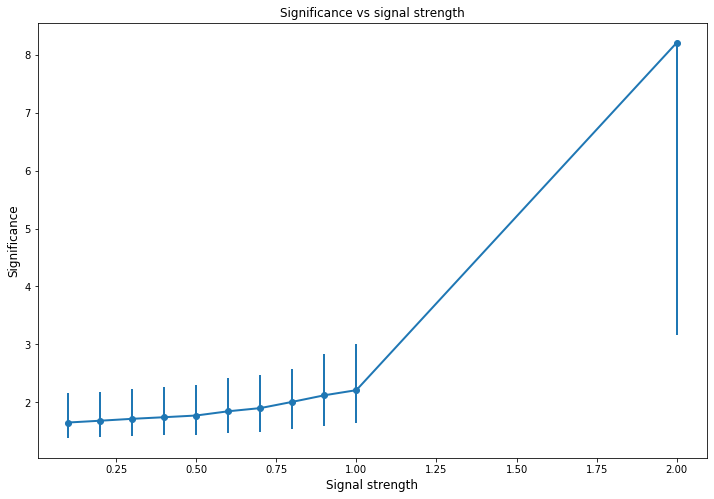

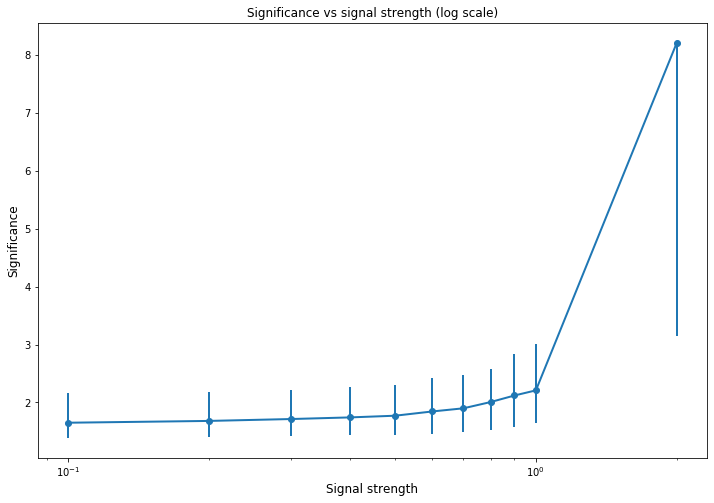

In [11]:
# Get the injection plot (with linear and log scale axis)
BHtest.PlotInject()